## Visualisation of Sampling with Hamiltonian Monte Carlo and RWMCMC

This notebook includes the demonstartion of a sampling process from a highly correlated Gaussian distribution with Hamiltonian Monte Carlo and random walk MHMCMC, based on Neal, 2011. Furter below you can compute the rejection rate and plot parameters temporally for both algorithms.

In [1]:
#OS: Ubuntu 16.04.2
#Python version 3.5.2
#IPython 6.0.0
import numpy as np #Version 1.13.2
from numpy.linalg import inv 
import matplotlib.pyplot as plt #Version 2.0.0
import matplotlib.animation as animation
from scipy.misc import imread #Version 0.19.0
from scipy.stats import multivariate_normal
%matplotlib nbagg

In [2]:
#Number of samples
n_samples = 30

#No. of leapfrog steps
no_steps = 30

#Leapfrog step size
eps = 0.1

In [3]:
#The target distribution: Highly correlated 2D Gaussian
mu = [0,0]
sigma = [[1,0.98],[0.98,1]]
mvn = multivariate_normal(mu, sigma)

In [4]:
%%capture
#Make sure you run this cell once each time you change the sigma value above

#This cell draws the background for the animations and saves them as an image
#to increase the speed of animation
def save_plot(mu, sigma):
    #Plotting the background
    fig, ax = plt.subplots(1, figsize=(5,5))
    x_p = np.arange(-3,3.1, 0.05); y_p = np.arange(-3,3.1, 0.05).T
    mv_nom_ = multivariate_normal(mean=mu, cov=sigma)
    X_p, Y_p = np.meshgrid(x_p, y_p)
    pos = np.empty(X_p.shape + (2,))
    pos[:, :, 0] = X_p; pos[:, :, 1] = Y_p
    Z_p = mv_nom_.pdf(pos)

    ax.scatter(x=X_p, y=Y_p, c=Z_p, s=150)
    ax.set_ylim(-3,3); ax.set_xlim(-3,3)
    ax.set_yticklabels([]); ax.set_xticklabels([])
    fig.tight_layout(pad=0)
    plt.savefig("background.png", bbox_inches=0)

save_plot(mu, sigma)

## Hamiltonian Monte Carlo

In [5]:
#The distribution for the momentum
mu_k = [0,0]
sigma_k = [[1,0],[0,1]]
mvn_k = multivariate_normal(mu_k, sigma_k)

#Initializing q
q = [-1.5,-1.5] + np.random.normal(0, 0.1, size=2)

samples=[]
background_pic = "background.png"
#Potential energy evaluation function
def U(q):
    #return -np.log(mvn.pdf(q))
    return np.dot(np.dot(q, inv(sigma)), q)/2

#Kinetic energy evaluation function
def K(p):
    return np.dot(p,p)/2

#Gradient of the potential energy function given a 2-dim zero mean Gaussian 
#with sigma covariance matrix w/o normalisation
def grad_U(q):
    return np.dot((inv(sigma)+inv(sigma).T),q)/2

#Gradient of the kinetic energy function given a 2-dim zero mean Gaussian 
#with identity cov. mat. w/o normalisation
def grad_K(p):
    return p 

#Iterating HMC for N samples
for n in range(n_samples):
    #a random p is drawn from its distribution
    p = mvn_k.rvs()
    
    #Initial values for q and p for at the start of this iteration
    q_init = q
    p_init = p

    #recording
    samples.append({"q":q_init, "p":p_init, "steps":[], "momenta":[]})

    #Simulating the Hamiltonian system for no_steps, with a step size of eps
    for step in range(no_steps):
        #p(t + eps/2) = p(t) - eps/2 * grad_U(q(t))
        p_ = p - (eps/2)*grad_U(q)
        #q(t + eps) = q(t) + eps * grad_K(p(t + eps/2))
        q = q + eps*grad_K(p_)
        #p(t + eps) = p(t + eps/2) - eps/2 * grad_U(q(t + eps))
        p = p_ - (eps/2)*grad_U(q)
        
        #recording q and p at every step
        samples[n]["steps"].append(q)
        samples[n]["momenta"].append(p)
    
    #Reversing the momentum vector for reversability a la Neal 2011
    p = -p
    
    #the alpha value calculated
    alpha = min(1, np.exp(U(q_init) + K(p_init) - U(q) - K(p)))
    
    #if accepted, keep the new sample
    if np.random.rand() < alpha:
        samples[n]["accepted"] = True
        pass
    #if rejected, revert to the previous sample
    else:
        samples[n]["accepted"] = False
        q = q_init

<IPython.core.display.Javascript object>


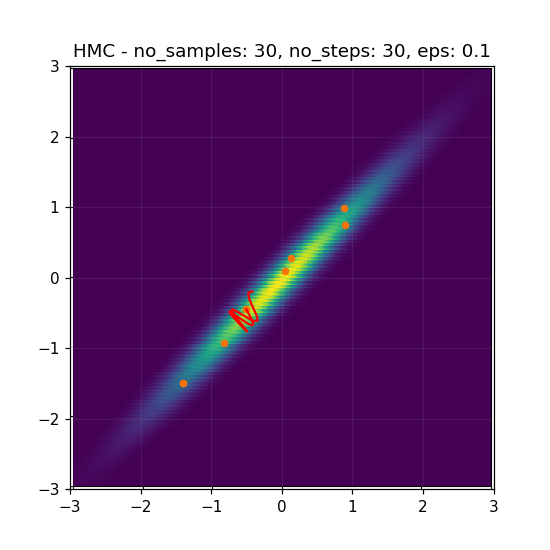

In [6]:
"""
Animating the sampling process
"""

q_init = samples[0]["q"]
dataset = np.array([x["steps"] for x in samples[:-1]]).reshape(-1,2)
qs = np.array([x["q"] for x in samples]).reshape(-1,2)

def line_data():
    #dataset = data_gen.dataset
    cnt = 0
    while cnt < len(dataset)+1:
        beg = no_steps * (cnt // no_steps)
        fin = beg + cnt % no_steps + 1
        x = dataset[beg:fin, 0].flatten()
        y = dataset[beg:fin, 1].flatten()
        x = np.insert(x, 0, qs[cnt // no_steps, 0])
        y = np.insert(y, 0, qs[cnt // no_steps, 1])
        cnt+=1
        yield x,y, cnt


fig, ax = plt.subplots(1, figsize=(5,5))

line, = ax.plot([], [], c="r")
ax.scatter(x=qs[0,0], y=qs[0,1], s=15, c="xkcd:orange")
scat = ax.scatter(x=qs[0,0], y=qs[0,1], s=15, c="xkcd:orange")

ax.set_ylim(-3, 3)
ax.set_xlim(-3, 3)
ax.grid(alpha=0.1)
im = imread(background_pic)
x_, y_ = [], []

def run_line(data):
    # update the data
    cnt = data
    x_, y_, cnt = data
    # update the data of both line objects
    line.set_data(x_, y_)
    scat.set_offsets(qs[:((cnt)//(no_steps))+1])

    return line, scat

plt.imshow(im, zorder=0,  extent=[-3, 3, -3, 3])
ani = animation.FuncAnimation(fig, run_line, line_data, interval=20,
    repeat=False)
ax.set_title("HMC - no_samples: {}, no_steps: {}, eps: {}".format(n_samples, no_steps, eps))

plt.show()

## Hamiltonian Monte Carlo

In [7]:
#random walk proposal distribution
mu_k = [0,0]
sigma_k = [[0.1,0],[0,0.1]]
mvn_k = multivariate_normal(mu_k, sigma_k)

samples_rw=[]

#initializing q
q = [-1.5,-1.5] + np.random.normal(0, 0.1, size=2)

#for N samples
for n in range(n_samples):
    
    #Recording the initial q
    q_init = q
        
    samples_rw.append({"q":q})

    #the proposal
    prop = q + mvn_k.rvs()
    samples_rw[n]["prop"] =prop
    #the alpha value calculated
    alpha = min(1, mvn.pdf(prop)/mvn.pdf(q_init))
    
    #if accepted, keep the proposed sample
    if np.random.rand() < alpha:
        samples_rw[n]["accepted"] = True
        q = prop
        pass
    #if rejected, revert to the previous sample
    else:
        samples_rw[n]["accepted"] = False
        q = q_init

<IPython.core.display.Javascript object>


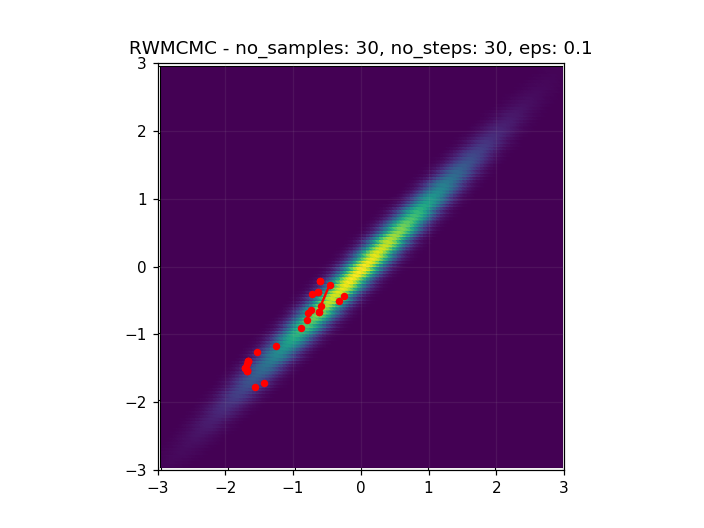

In [8]:
"""
Animating the sampling process
"""

q_init = samples_rw[0]["q"]
dataset = np.array([[x["q"],x["prop"]] for x in samples_rw[:-1]]).reshape(-1,2)
qs = np.array([x["q"] for x in samples_rw]).reshape(-1,2)

def line_data():
    #dataset = data_gen.dataset
    cnt = 0
    while cnt < len(dataset)/2:
        beg = cnt*2
        fin = cnt*2 +2 
        x = dataset[beg:fin, 0].flatten()
        y = dataset[beg:fin, 1].flatten()
            
        cnt+=1
        yield x,y, cnt

fig, ax = plt.subplots()
line, = ax.plot([], [], c="r")
plt.scatter(x=qs[0,0], y=qs[0,1], s=15, c="red")
scat = ax.scatter(x=qs[0,0], y=qs[0,1], s=15, c="red")

ax.set_ylim(-3, 3)
ax.set_xlim(-3, 3)
ax.grid(alpha=0.1)
im = imread(background_pic)
x_, y_ = [], []

def run_line(data):
    # update the data
    x_, y_, cnt = data
    # update the data of both line objects
    line.set_data(x_, y_)
    scat.set_offsets(qs[:cnt+1])
    return line

ax.set_title("RWMCMC - no_samples: {}, no_steps: {}, eps: {}".format(n_samples, no_steps, eps))
plt.imshow(im,zorder=0,  extent=[-3, 3, -3, 3])
ani = animation.FuncAnimation(fig, run_line, line_data, blit=True, interval=200,
    repeat=False)

plt.show()

# Diagnostics

In [9]:
rejection_rate = 1 - np.mean([x["accepted"] for x in samples])
print("Rejection rate for HMC = {}".format(rejection_rate))
rejection_rate = 1 - np.mean([x["accepted"] for x in samples_rw])
print("Rejection rate for RWMCMC = {}".format(rejection_rate))

Rejection rate for HMC = 0.0
Rejection rate for RWMCMC = 0.33333333333333337


<IPython.core.display.Javascript object>


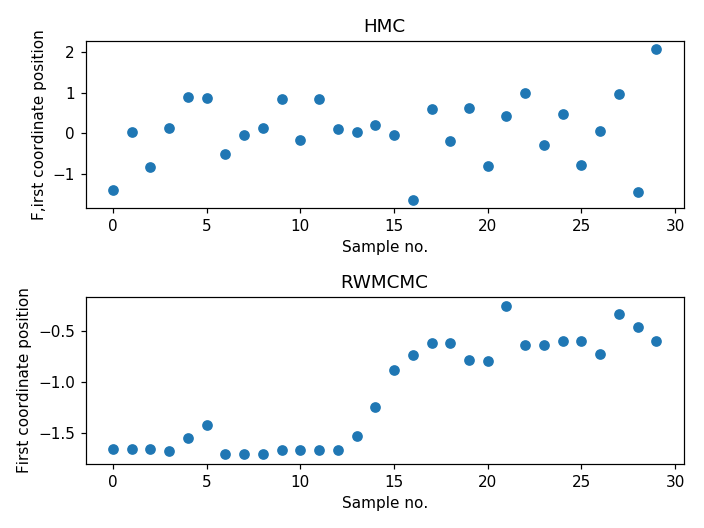

In [10]:
q_0_hmc = [x["q"][0] for x in samples]
fig, axes = plt.subplots(2,1)
#plt.suptitle("First position coordinates for N samples")
axes[0].scatter(range(len(q_0_hmc)), q_0_hmc)
axes[0].set_title("HMC")
axes[0].set_xlabel("Sample no.")
axes[0].set_ylabel("F,irst coordinate position")

q_0_rw = [x["q"][0] for x in samples_rw]
axes[1].scatter(range(len(q_0_rw)), q_0_rw)
axes[1].set_title("RWMCMC")
axes[1].set_xlabel("Sample no.")
axes[1].set_ylabel("First coordinate position")

plt.tight_layout()
